In [2]:
import numpy as np
import matplotlib.pyplot as plt
import openfermion as of
from openfermionpyscf import run_pyscf
import stim
from src.preprocessing.calc_clifford_transforms import clifford_transform_multiple_groups_to_zs
from src.preprocessing.commuting_groups import commuting_groups
from src.utils import qubitop_to_stim_pauli_strings

%load_ext scalene

LOADING
Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


In [5]:
import itertools
def random_pauli_xs(n, num):
    vecs = np.random.choice([0, 1], size=(num, n))
    qops = [of.QubitOperator(' '.join([f'X{i}' for i in range(n) if vec[i]])) for vec in vecs]
    return qops

def all_pauli_xs(n):
    binary_arrays = list(itertools.product([0, 1], repeat=n))
    paulistrings = []
    for j, vec in enumerate(binary_arrays):
        ps = stim.PauliString(n)
        for i in range(n):
            if vec[i]:
                ps[i] = 1
        paulistrings.append(ps)
    return paulistrings

ns = list(range(5,15))
fillings = []
for n in ns:
    group_idxs = [np.arange(2**n)]
    operator_groups = [all_pauli_xs(n)]

    tableaus, pauli_idxs = clifford_transform_multiple_groups_to_zs(operator_groups, group_idxs, n)
    print(pauli_idxs)
    fillings.append(np.mean([len(idx) for idx in pauli_idxs]) / n)

plt.plot(ns, fillings)


[[0, 1, 2, 4, 8], [3, 5, 7, 9, 16], [6, 10, 11, 14, 17], [12, 13, 15, 18, 20], [19, 21, 22, 23, 24], [25, 26, 27, 28], [29, 30, 31]]
[[0, 1, 2, 4, 8, 16], [3, 5, 7, 9, 17, 32], [6, 10, 11, 14, 18, 33], [12, 13, 15, 19, 20, 34], [21, 22, 23, 24, 28, 35], [25, 26, 27, 29, 36, 40], [30, 31, 37, 38, 41, 44], [39, 42, 43, 45, 46, 48], [47, 49, 50, 51, 52, 56], [53, 54, 55, 57, 60], [58, 59, 61, 62], [63]]
[[0, 1, 2, 4, 8, 16, 32], [3, 5, 7, 9, 17, 33, 64], [6, 10, 11, 14, 18, 34, 65], [12, 13, 15, 19, 20, 35, 66], [21, 22, 23, 24, 28, 36, 67], [25, 26, 27, 29, 37, 40, 68], [30, 31, 38, 41, 42, 44, 69], [39, 43, 45, 46, 47, 48, 70], [49, 50, 51, 52, 56, 71, 80], [53, 54, 55, 57, 60, 72, 81], [58, 59, 61, 62, 73, 82, 88], [63, 74, 75, 76, 78, 83, 89], [77, 79, 84, 85, 90, 92, 96], [86, 87, 91, 93, 94, 97, 112], [95, 98, 99, 100, 102, 104, 113], [101, 103, 105, 106, 108, 114], [107, 109, 110, 111, 115, 120], [116, 117, 118, 121, 124], [119, 122, 123, 125, 126], [127]]
[[0, 1, 2, 4, 8, 16, 32, 

KeyboardInterrupt: 

Text(0, 0.5, 'filling')

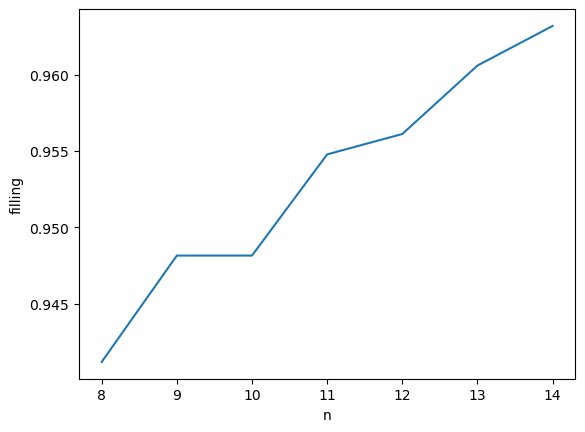

In [ ]:
plt.plot(ns[3:], fillings[3:])
plt.xlabel("n")
plt.ylabel("filling")

In [ ]:
import pandas as pd

data = {'ns': ns, 'fillings': fillings}
df = pd.DataFrame(data)
df.to_csv('data.csv', index=False)


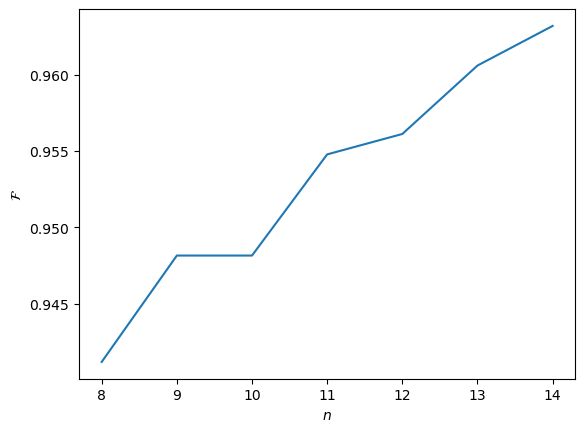

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('data/qromfillingdata.csv')

plt.plot(df["ns"][3:], df["fillings"][3:])
plt.xlabel(r"$n$")
plt.ylabel(r"$\mathcal{F}$")
plt.savefig('qromfilling.pdf', format='pdf')

In [ ]:
%%scalene
# also get some filling factors for hamiltonians generated by openfermion
# need a list of molecules to test with differing number of qubits
from openfermion.chem import geometry_from_pubchem
molecule_names = ["molecular hydrogen", "lithium hydride", "water", "ammonia", "methane", "oxygen", "molecular nitrogen", "ethane", "disodium", 
                  # "XVOFZWCCFLVFRR-UHFFFAOYSA-N" # CrO oxochromium
                  ]
molecule_names = ["methane"]
geometries = [geometry_from_pubchem(name) for name in molecule_names]
moleculeData = []
for i, geometry in enumerate(geometries):
    basis = "sto-3g"
    molecule = of.MolecularData(geometry, basis, 1)
    mol = run_pyscf(molecule)
    moleculeData.append((mol.n_qubits, mol, molecule_names[i], basis))
# for i, geometry in enumerate(geometries[:-3]):
#     basis = "6-31g"
#     molecule = of.MolecularData(geometry, basis, 1)
#     mol = run_pyscf(molecule)
#     moleculeData.append((mol.n_qubits, mol, molecule_names[i], basis))

hamiltonianData = []
for md in moleculeData:
    print(md[2], md[3])
    ham = of.transforms.jordan_wigner(of.transforms.get_fermion_operator(md[1].get_molecular_hamiltonian()))
    print(len(ham.terms))
    hamiltonianData.append((md[0], len(ham.terms) ,  ham, md[2], md[3]))
hamiltonianData = sorted(hamiltonianData, key=lambda x: x[1])

hamiltonians = [hd[2] for hd in hamiltonianData]
ns = [hd[0] for hd in hamiltonianData]
fillings = []
for i, hamiltonian in enumerate(hamiltonians):
    n = ns[i]
    print(n, len(hamiltonian.terms))
    operator_groups, group_idxs = commuting_groups(hamiltonian, n)
    print("calculated operator groups")
    tableaus, pauli_idxs = clifford_transform_multiple_groups_to_zs(operator_groups, group_idxs, n)
    fillings.append(np.mean([len(idx) for idx in pauli_idxs]) / n)

In [3]:
# read moleculefillingdata.csv
import pandas as pd
df = pd.read_csv('data/moleculefillingdata.csv', skipinitialspace=True)
df

,n_qubits,n_terms,filling,name,basis
0,4,15,0.625000,molecular hydrogen,sto-3g
1,8,185,0.642361,molecular hydrogen,6-31g
2,12,631,0.473724,lithium hydride,sto-3g
3,14,1390,0.491513,water,sto-3g
4,20,2239,0.478419,oxygen,sto-3g
5,20,2951,0.528853,molecular nitrogen,sto-3g
6,16,4929,0.572607,ammonia,sto-3g
7,18,8480,0.571737,methane,sto-3g
8,22,8750,0.526791,lithium hydride,6-31g
9,26,13884,0.499065,water,6-31g


['molecular hydrogen', 'lithium hydride', 'ammonia', 'molecular nitrogen', 'disodium', 'oxygen', 'methane', 'water', 'ethane']


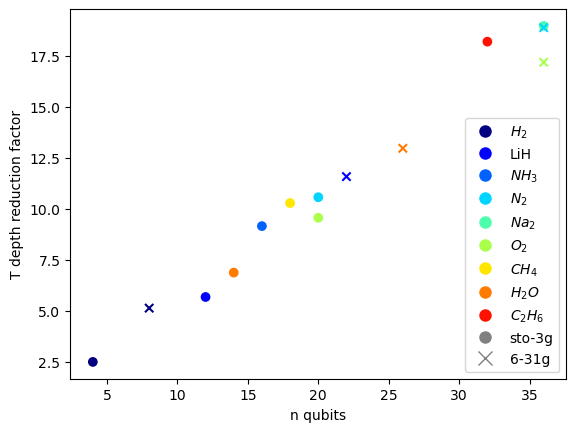

In [13]:
# plot n_qubits vs the filling in the dataframe
fig, ax = plt.subplots()
# generate a unique color for each name in df["name"]
cmap = plt.cm.jet
set_names = list(set(df["name"]))
names_to_colors = {set_name: cmap(i/len(set_names)) for i, set_name in enumerate(set_names)}
plot_colors = [names_to_colors[name] for name in df["name"]]
# generate a symbol for each basis in df["basis"]
set_basis = list(set(df["basis"]))
basis_to_symbol = {set_basis[i]: ['o', 'x', '+', 's', 'd'][i] for i in range(len(set_basis))}
plot_symbols = [basis_to_symbol[basis] for basis in df["basis"]]
# call scatter once for each marker type
for basis, symbol in basis_to_symbol.items():
    mask = df["basis"] == basis
    plot_colors = [names_to_colors[name] for name in df[mask]["name"]]
    ax.scatter(df[mask]['n_qubits'], df[mask]['n_qubits']*df[mask]['filling'], marker=symbol, c=plot_colors)
# this is when using usual fanout scheme on the ancilla register

name_to_formula = {
    'methane': '$CH_4$',
    'water': '$H_2 O$',
    'molecular hydrogen': '$H_2$',
    'disodium': '$Na_2$',
    'lithium hydride': 'LiH',
    'oxygen': '$O_2$',
    'ethane': '$C_2H_6$',
    'molecular nitrogen': '$N_2$',
    'ammonia': '$NH_3$'
}

# make a legend that matches the colors to the names
print(set_names)
formula_set_names = []
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=name_to_formula[name], markerfacecolor=names_to_colors[name], markersize=10) for name in set_names]
legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label="sto-3g", markerfacecolor='grey', markersize=10))
legend_elements.append(plt.Line2D([0], [0], marker='x', color='w', label="6-31g", markeredgecolor='grey', markersize=10))
ax.legend(handles=legend_elements, loc='lower right')
ax.set_xlabel("n qubits")
ax.set_ylabel("T depth reduction factor")
fig.savefig("molecule_t_depth_reduction.pdf", format="pdf")
